#RAG.

## Установка и импорт библиотек

In [ ]:
pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl datasets langchain-community ragatouille umap-learn matplotlib plotly sentencepiece pymorphy2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from platform import python_version

print(python_version())

3.10.12


In [ ]:
import gdown
import os
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple, Union
import matplotlib.pyplot as plt

import base64
import requests
from PIL import Image
import PIL
from io import BytesIO

import re
import string
import nltk
import pymorphy2
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import pipeline
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer

from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from ragatouille import RAGPretrainedModel
from transformers import Pipeline

from sklearn.decomposition import PCA
import umap

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/detimokhin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!nvidia-smi
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

Sun Dec 29 20:32:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8              9W /  170W |     253MiB /  12288MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

'cuda'

In [ ]:
SEED = 42

def seed_torch(seed:int=42):
    """
    Функция для фиксации воспроизведения расчетов
        seed:int - параметр фиксации
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
seed_torch(SEED)

## Загрузка данных (4 балла)

In [ ]:
NEED_DOWNLOAD = False
if NEED_DOWNLOAD:
  url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
  output = 'file.csv'

  gdown.download(url, output, quiet=False)
else:
  print('Данные загружены')

Данные загружены


In [ ]:
data_orig = pd.read_csv('file.csv')
print(data_orig.shape)
data_orig.head(2)

(14634, 9)


,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...


используем для декодирования изображений

In [ ]:
def get_image(data):

    image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
    return image

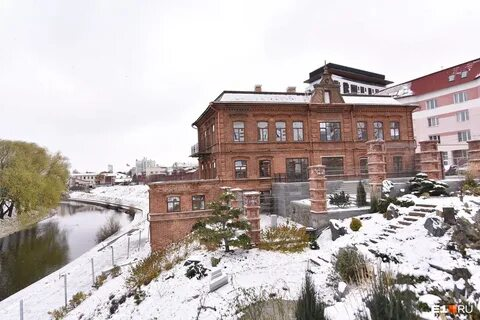

In [ ]:
get_image(data_orig.sample(1)['image'].tolist()[0])

Так как в данных есть выбросы попробуем от них избавиться.
для начала воспользуемся TF-IDF для получения наиболее редких и частых слов

In [ ]:
data_orig.columns

Index(['Unnamed: 0', 'Name', 'WikiData', 'City', 'Lon', 'Lat', 'description',
       'image', 'en_txt'],
      dtype='object')

In [ ]:
need_cols = ['Name', 'City', 'description', 'image', 'en_txt']
data_orig = data_orig[need_cols]
print(data_orig.shape)
data_orig.head()

(14634, 5)


,Name,City,description,image,en_txt
0,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


In [ ]:
display(data_orig.nunique(), data_orig.describe())

Name             387
City               4
description      245
image          13281
en_txt         10154
dtype: int64

,Name,City,description,image,en_txt
count,14634,14634,12078,14634,14634
unique,387,4,245,13281,10154
top,Владимир,Ярославль,Православный храм в Ярославле,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAICAgICAQICAg...,arafed view of a large white building with gol...
freq,114,4372,605,10,83


In [ ]:
data = data_orig.groupby(['Name', 'City', 'description']).agg({'image': set, 'en_txt': set}).reset_index()
print(data.shape)
data.head()

(320, 5)


,Name,City,description,image,en_txt
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed church with a green roof and a steeple...
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed view of a church with a golden cross i...
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small pink building with a steeple...
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{a computer generated image of a rocky landsca...
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed image of a building with a bunch of pe...


In [ ]:
list(data['en_txt'][0])

['arafed church with a green roof and a steeple',
 'there is a wooden building with a wooden fence and a wooden fence',
 'there is a wooden church with two steeples on top of it',
 'there are two crosses in front of a church in the woods',
 'there is a small church with a steeple on the top of it',
 'arafed wooden church with steeple and steeple on the front',
 'arafed wooden building with a steeple and a roof',
 'arafed wooden church with a steeple and a blue roof',
 'there are two wooden buildings with flags on the fence',
 'there is a large wooden building with a steeple on top',
 'arafed wooden church with a steeple and a steeple on the roof',
 'there are two wooden buildings in the middle of a field',
 'arafed wooden building with a steeple and a cross on the top',
 'arafed wooden church with steeple and steeple on top',
 'arafed view of a white building with a green dome',
 'arafed wooden buildings with a steeple and a fence',
 'there is a wooden building with a steeple on the to

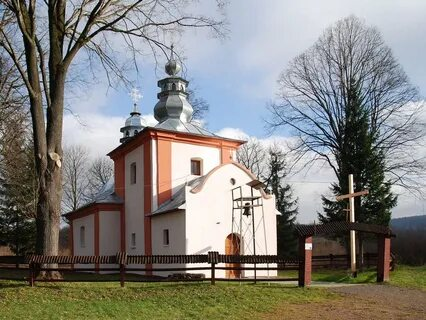

In [ ]:
get_image(list(data['image'][0])[0])

In [ ]:
print(f'Количество уникальных городов: {data.City.nunique()}')
data.City.value_counts()

Количество уникальных городов: 4


City
Нижний Новгород    98
Екатеринбург       97
Ярославль          96
Владимир           29
Name: count, dtype: int64

In [ ]:
data.isna().mean()

Name           0.0
City           0.0
description    0.0
image          0.0
en_txt         0.0
dtype: float64

In [ ]:
for i in need_cols:
    data[f'len_{i}'] = data[i].apply(lambda x: len(str(x)))
display(data.describe())

,len_Name,len_City,len_description,len_image,len_en_txt
count,320.000000,320.000000,320.000000,3.200000e+02,320.000000
mean,26.537500,11.656250,33.290625,1.714635e+06,2039.503125
std,12.935765,2.609476,21.594436,5.490707e+05,658.010552
min,4.000000,8.000000,5.000000,9.640800e+05,991.000000
25%,18.000000,9.000000,22.000000,1.307805e+06,1621.750000
50%,25.000000,12.000000,29.000000,1.510466e+06,1755.500000
75%,32.000000,15.000000,38.000000,1.989991e+06,2448.750000
max,76.000000,15.000000,225.000000,3.320324e+06,3785.000000


In [ ]:
data.groupby('description').Name.count().sort_values(ascending=False).reset_index().head()

,description,Name
0,Православный храм в Ярославле,13
1,здание в Екатеринбурге,10
2,музей в Екатеринбурге,8
3,круглая башня Нижегородского кремля,8
4,проездная башня Нижегородского кремля,4


In [ ]:
# Загрузка предтренировочной модели для машинного перевода

MODEL_TRANS_NAME = "facebook/mbart-large-50-many-to-many-mmt"
SRC_LANG = "ru_RU"  # Код языка для русского
TRG_LANG = "en_XX"   # Код языка для английского

# Функция для перевода текста
def translate(model_trans,
              tokenizer_trans,
              text:str,
              src:str=SRC_LANG,
              dest:str=TRG_LANG):
    """
    Функция для перевода текста
        model_trans - предобученная модель машинного перевода
        tokenizer_trans - токенизатор модели
        text:str - текст для перевода
        src:str - код языка с которого необходимо перевести
        dest:str - код языка на который необходимо перевести
    """
    tokenizer_trans.src_lang = src
    encoded_input = tokenizer_trans(text, return_tensors="pt").to(DEVICE)


    generated_tokens = model_trans.generate(**encoded_input, forced_bos_token_id=tokenizer_trans.lang_code_to_id[dest])

    return tokenizer_trans.batch_decode(generated_tokens, skip_special_tokens=True)[0]


try:
    MODEL_TRANS = MBartForConditionalGeneration.from_pretrained(MODEL_TRANS_NAME).to(DEVICE)
    TOKENIZER_TRANS = MBart50TokenizerFast.from_pretrained(MODEL_TRANS_NAME)
    print(f"Модель и токенизатор загружены успешно!")
except Exception as e:
    print(f"Ошибка при загрузке: {e}")

Модель и токенизатор загружены успешно!


In [ ]:
# Проверка кода
source_text = data['description'][0] # первое описние из датасета
translated_text = translate(MODEL_TRANS, TOKENIZER_TRANS, source_text)
print(f'На русском: {source_text} \nНа английском: {translated_text}')

На русском: Православный храм в Ярославле 
На английском: Orthodox Church in Yaroslavl


In [ ]:
%%time

ru_corpus = set(data.description)
trans_ru_to_en = {k:v for k, v in zip(ru_corpus, [translate(model_trans=MODEL_TRANS,
                                                            tokenizer_trans=TOKENIZER_TRANS,
                                                            text=x) for i, x in tqdm(enumerate(ru_corpus))])}
data['en_description'] = data['description'].map(trans_ru_to_en)

0it [00:00, ?it/s]

CPU times: user 40.1 s, sys: 4.25 s, total: 44.4 s
Wall time: 45.6 s


In [ ]:
need_cols = ['Name', 'City', 'description', 'image', 'en_txt', 'en_description']
data_filterd = data[need_cols].copy()
print(data_filterd.shape)
data_filterd.head()

(320, 6)


,Name,City,description,image,en_txt,en_description
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed church with a green roof and a steeple...,Orthodox Church in Yaroslavl
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed view of a church with a golden cross i...,Architectural ensemble in Yaroslavl
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small pink building with a steeple...,Church of St. Demetrius of Alexandria (Smolens...
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{a computer generated image of a rocky landsca...,"Armenian Church in Vladimir, Russia"
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed image of a building with a bunch of pe...,Vladimir Aviation Mechanical College


In [ ]:
ENG_STOP_WORDS = list(set(stopwords.words('english')))
RUS_STOP_WORDS = list(set(stopwords.words('russian')))
STOP_WORDS = ENG_STOP_WORDS + RUS_STOP_WORDS
STOP_WORDS.append('none')
PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer()
MORPH_ANALYZER = pymorphy2.MorphAnalyzer()

def preprocess_text(text, norm_tokens: bool=True, stopwords: set=(), del_ru: bool=True):
    """
    Функция предобработки текста
        text - текст
        norm_tokens - флаг нормализации текста
        stopwords - стопслова
        del_ru - необходимость удалять русские слова или наоборот
    """
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    if del_ru:
        word_filtered_text = re.sub(r'[^a-zA-Z\s]+', '', nums_filtered_text)
    else:
        word_filtered_text = re.sub(r'[a-zA-Z]+', '', nums_filtered_text)
    punct_filtered_text = ''.join([ch for ch in word_filtered_text if ch
                                   not in string.punctuation])
    tokens = PUNCT_WORD_TOKENIZER.tokenize(punct_filtered_text)
    if len(stopwords) != 0:
      tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens
                if token not in stopwords]
    if norm_tokens:
        tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens]

    return ' '.join(tokens)


def unique_words(text):
    """
    Функция извлечения уникальных слов из текста
        text - текст
    """
    words = text.split()
    unique_words = list(set(words))
    return ' '.join(unique_words)

In [ ]:
data_filterd['image'] = data_filterd.image.apply(lambda x: list(x))
data_filterd['all_en_txt'] = data_filterd.en_txt.apply(lambda x: ' '.join(list(x)))
data_filterd['all_en_txt'] = data_filterd[['en_description', 'all_en_txt']].apply(lambda x: ' '.join(x), axis=1)

data_filterd['processed_text'] = (data_filterd['all_en_txt']
                                  .apply(lambda x: preprocess_text(text=x
                                                                   , norm_tokens = True
                                                                   , stopwords=STOP_WORDS
                                                                   )
                                         )
                                  )

data_filterd['unique_processed_text'] = (data_filterd['processed_text']
                                         .apply(lambda x: unique_words(text=x)
                                                )
                                         )

print(data_filterd.shape)
data_filterd.head(2)

(320, 9)


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed church with a green roof and a steeple...,Orthodox Church in Yaroslavl,Orthodox Church in Yaroslavl arafed church wit...,orthodox church yaroslavl arafed church green ...,structure fence arafed woods buildings steeple...
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed view of a church with a golden cross i...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl arafed vie...,architectural ensemble yaroslavl arafed view c...,mary bell close buildings steeples people blue...


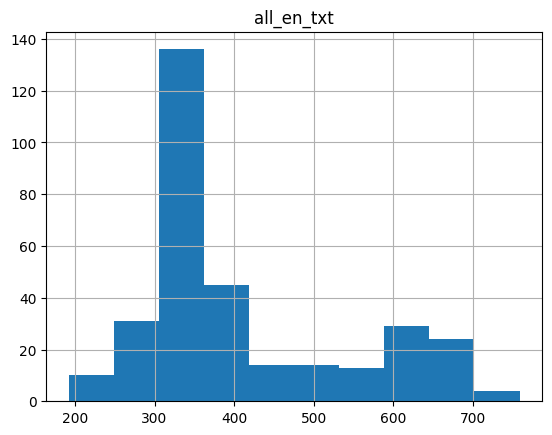

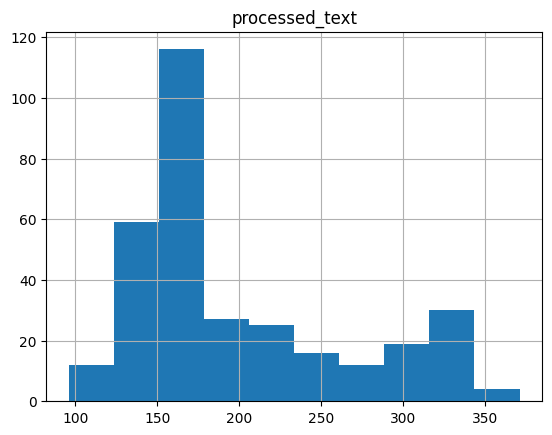

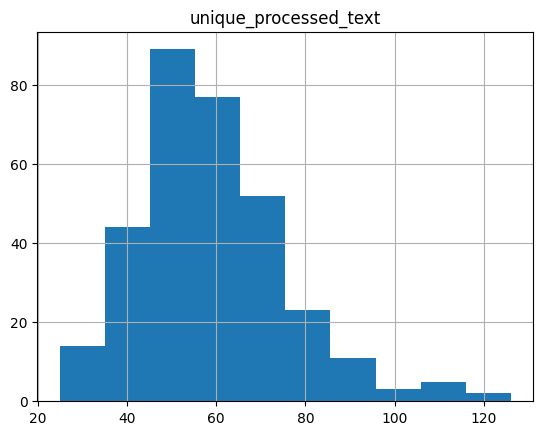

,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
count,320.00000,320.000000,320.000000
mean,410.14375,198.193750,59.484375
std,129.83099,65.650351,16.532283
min,192.00000,96.000000,25.000000
25%,324.00000,153.000000,49.000000
50%,356.00000,170.000000,57.000000
75%,488.75000,234.000000,69.000000
max,759.00000,371.000000,126.000000


In [ ]:
for i in ['all_en_txt', 'processed_text', 'unique_processed_text']:
    data_filterd[f'num_tokens_of_{i}'] = data_filterd[i].apply(lambda x: len(PUNCT_WORD_TOKENIZER.tokenize(x)))
    data_filterd[f'num_tokens_of_{i}'].hist()
    plt.title(i)
    plt.show()
data_filterd.describe()

In [ ]:
corpus_txt = data_filterd.unique_processed_text.tolist()

vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Применение TF-IDF к текстовым данным
matrix = vectorizer.fit_transform(corpus_txt)
feature_names = vectorizer.get_feature_names_out()

all_score_df = (pd.DataFrame({'word': feature_names,
                              'score': matrix.toarray().sum(axis=0)})
                .sort_values('score')).reset_index(drop=True)
all_score_df

,word,score
0,group educational,0.078144
1,st emblem,0.078144
2,cake ribbon,0.078144
3,ties woman,0.078144
4,shirt picture,0.078144
...,...,...
9518,arafed,7.646253
9519,building,7.664942
9520,large,7.672744
9521,tower,7.693143


In [ ]:
def show_contains(df: pd.DataFrame,
                  column: str,
                  word: str):
    """
    Функция отображения контекта по входящему выражения
        df - датафрейм
        column - столбец, по которому проверяем вхождение
        word - слово / предложение, которое проверяем в column
    """

    df = df[df[column].str.contains(word)]
    name = df.Name.values[0]
    len_images = len(df['image'].values[0])

    display(df.head(3),
            print(f'Наименование объекта: {name}, количество картинок: {len_images}'),
        get_image(df['image'].values[0][np.random.randint(0,len_images)]))

Наименование объекта: Автомеханический техникум, количество картинок: 56


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
6,Автомеханический техникум,Ярославль,образовательное учреждение в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{students in a classroom with a teacher standi...,educational institution in Yaroslavl,educational institution in Yaroslavl students ...,educational institution yaroslavl students cla...,posing factory operate sign papers camera teac...,624,306,126


None

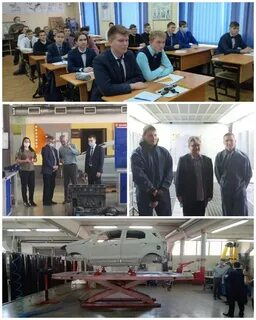

In [ ]:
show_contains(data_filterd, 'unique_processed_text', all_score_df['word'][0])

Наименование объекта: Автомеханический техникум, количество картинок: 56


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
6,Автомеханический техникум,Ярославль,образовательное учреждение в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{students in a classroom with a teacher standi...,educational institution in Yaroslavl,educational institution in Yaroslavl students ...,educational institution yaroslavl students cla...,posing factory operate sign papers camera teac...,624,306,126


None

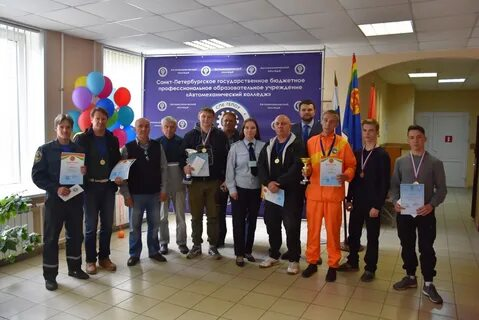

In [ ]:
show_contains(data_filterd, 'unique_processed_text', all_score_df['word'][1])

Наименование объекта: Cerkiew Włodzimierskiej Ikony Matki Bożej w Jarosławiu, количество картинок: 59


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed view of a church with a golden cross i...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl arafed vie...,architectural ensemble yaroslavl arafed view c...,mary bell close buildings steeples people blue...,653,322,96
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small pink building with a steeple...,Church of St. Demetrius of Alexandria (Smolens...,Church of St. Demetrius of Alexandria (Smolens...,church st demetrius alexandria smolensk yarosl...,bell ceremony wedding close woods book buildin...,644,304,77
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{a computer generated image of a rocky landsca...,"Armenian Church in Vladimir, Russia","Armenian Church in Vladimir, Russia a computer...",armenian church vladimir russia computer gener...,red color landscape coins arafed castle standi...,362,164,75


None

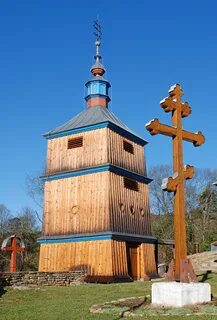

In [ ]:
show_contains(data_filterd, 'unique_processed_text', all_score_df['word'].iloc[-1])

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             min_df=0.1)

# Применение TF-IDF к текстовым данным
matrix = vectorizer.fit_transform(corpus_txt)
feature_names = vectorizer.get_feature_names_out()

need_score_df = (pd.DataFrame({'word': feature_names,
                               'score': matrix.toarray().sum(axis=0)})
                 .sort_values('score'))
need_score_df

,word,score
173,wall white,6.413503
13,bell,6.463907
28,carriage,6.495968
109,path view,6.613484
71,green clock,6.667837
...,...,...
36,clock,20.692355
80,large,20.898976
60,front,21.053471
22,building,21.164170


Попробую определить выбросы с помощью K-Means
для оптимального выбора k воспользуемся методом локтя и silhouette

In [ ]:
def choose_optimal_k_elbow(data, min_k: int=4, devide: int=10, step: int=100):
    """
    Функция определения оптимального количества кластеров по метрикам kmeans_score и silhouette
        data - датафрейм / матрица
        min_k - минимальное количество кластеров
        devide - значение делитель размера датафрейма
        step - шаг добавления кластеров
    """
    k_scores = []
    s_scores = []

    k_max = int(data.shape[0]/devide)

    k_values = range(min_k, k_max, step)

    for k in tqdm(k_values):
        kmeans = KMeans(n_clusters=k,
                        init='k-means++',
                        n_init=10,
                        max_iter=300,
                        tol=0.0001,
                        random_state=42)

        preds = kmeans.fit_predict(data)

        k_scores.append(-kmeans.score(data))

        # Silhouette Score
        silhouette = silhouette_score(data, preds)
        s_scores.append(silhouette)

    plt.plot(k_values, k_scores, marker='o')
    plt.title('Метод локтя')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Значение метрики')
    plt.show()

    plt.plot(k_values, s_scores, marker='o')
    plt.title('Метрика Silhouette KMeans модели при разном значении размера кластера')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Значение метрики')
    plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

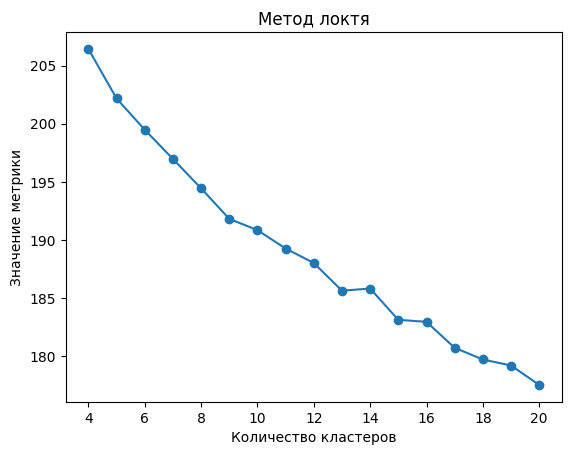

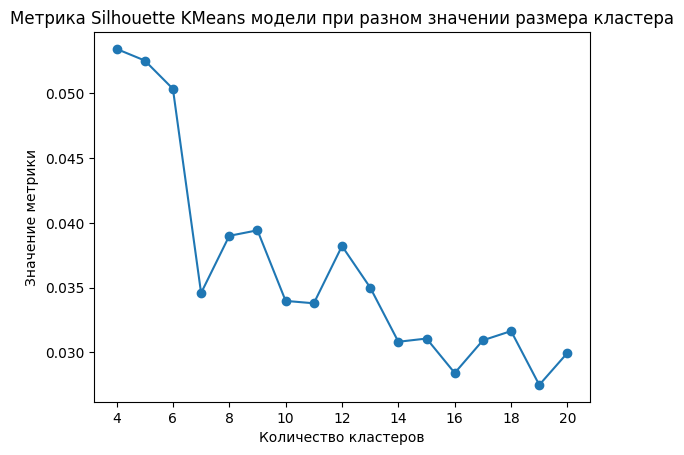

In [ ]:
choose_optimal_k_elbow(matrix, devide=15, step=1)

In [ ]:
km_clustering = KMeans(
    n_clusters=6,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001)

data_filterd['prediction'] = km_clustering.fit_predict(matrix)
prediction_counts = (data_filterd['prediction']
                     .value_counts()
                     .sort_values()
                     .reset_index()
                     .rename(columns={'count':'v_counts'})
                    )
prediction_counts.head()

,prediction,v_counts
0,1,31
1,4,39
2,0,45
3,3,49
4,5,60


In [ ]:
prediction_counts.describe()

,prediction,v_counts
count,6.000000,6.000000
mean,2.500000,53.333333
std,1.870829,23.053561
min,0.000000,31.000000
25%,1.250000,40.500000
50%,2.500000,47.000000
75%,3.750000,57.250000
max,5.000000,96.000000


In [ ]:
# 10% кластеров по value_counts и сортировке
need_clusters = (prediction_counts[prediction_counts['v_counts']
                 >=prediction_counts['v_counts'].quantile(0.1)]
                 .prediction)

# Посмотрим как меняется количество наблюдений после фильтрации
print(data_filterd.shape,
      data_filterd[data_filterd['prediction'].isin(need_clusters)].shape)

(320, 13) (289, 13)


In [ ]:
(
    data_filterd.City.value_counts(),
    data_filterd[data_filterd['prediction'].isin(need_clusters)].City.value_counts())

(City
 Нижний Новгород    98
 Екатеринбург       97
 Ярославль          96
 Владимир           29
 Name: count, dtype: int64,
 City
 Ярославль          92
 Екатеринбург       91
 Нижний Новгород    79
 Владимир           27
 Name: count, dtype: int64)

In [ ]:
data_filterd = data_filterd[data_filterd['prediction'].isin(need_clusters)]
print(data_filterd.shape)
data_filterd.head()

(289, 13)


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed church with a green roof and a steeple...,Orthodox Church in Yaroslavl,Orthodox Church in Yaroslavl arafed church wit...,orthodox church yaroslavl arafed church green ...,structure fence arafed woods buildings steeple...,265,130,30,2
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed view of a church with a golden cross i...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl arafed vie...,architectural ensemble yaroslavl arafed view c...,mary bell close buildings steeples people blue...,653,322,96,2
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small pink building with a steeple...,Church of St. Demetrius of Alexandria (Smolens...,Church of St. Demetrius of Alexandria (Smolens...,church st demetrius alexandria smolensk yarosl...,bell ceremony wedding close woods book buildin...,644,304,77,2
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{a computer generated image of a rocky landsca...,"Armenian Church in Vladimir, Russia","Armenian Church in Vladimir, Russia a computer...",armenian church vladimir russia computer gener...,red color landscape coins arafed castle standi...,362,164,75,2
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed image of a building with a bunch of pe...,Vladimir Aviation Mechanical College,Vladimir Aviation Mechanical College arafed im...,vladimir aviation mechanical college arafed im...,factory bell red sitting robots snowy bicycle ...,343,167,64,5


In [ ]:
data_filterd.City.value_counts()

City
Ярославль          92
Екатеринбург       91
Нижний Новгород    79
Владимир           27
Name: count, dtype: int64

In [ ]:
data_filterd.City.value_counts()

City
Ярославль          92
Екатеринбург       91
Нижний Новгород    79
Владимир           27
Name: count, dtype: int64

In [ ]:
for i in ['Name', 'City', 'description']:
    data_filterd[f'len_{i}'] = data_filterd[i].apply(lambda x: len(str(x)))
display(data_filterd.describe())

,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,409.276817,197.788927,59.820069,2.750865,27.276817,11.491349,33.560554
std,130.808010,66.477025,16.609762,1.626668,13.083314,2.565955,22.543722
min,192.000000,96.000000,25.000000,0.000000,4.000000,8.000000,5.000000
25%,326.000000,153.000000,50.000000,2.000000,18.000000,9.000000,21.000000
50%,355.000000,169.000000,57.000000,3.000000,25.000000,12.000000,29.000000
75%,475.000000,233.000000,69.000000,4.000000,32.000000,15.000000,38.000000
max,759.000000,371.000000,126.000000,5.000000,76.000000,15.000000,225.000000


In [ ]:
data_filterd[data_filterd.len_description==5]

,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
130,Литературная жизнь Урала XX века,Екатеринбург,Музей,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small wooden building with a metal...,Museum,Museum there is a small wooden building with a...,museum small wooden building metal roof displa...,red snowy sign fence arafed standing porch cam...,274,124,54,4,32,12,5


не удалось избавиться от всех выбросов, поэтому оставшиеся попробую удалить вручную

### Ручная отчистка

In [ ]:
(
    data_filterd.Name.nunique(),
    data_filterd.Name.unique().tolist())

(287,
 ['Cerkiew Narodzenia Pańskiego w Jarosławiu',
  'Cerkiew Włodzimierskiej Ikony Matki Bożej w Jarosławiu',
  'Cerkiew św. Dymitra Sołuńskiego w Jarosławiu',
  'église arménienne de Vladimir',
  'Авиамеханический колледж',
  'Автозаводский парк культуры и отдыха',
  'Автомеханический техникум',
  'Администрация Нижнего Новгорода',
  'Александро-Невская часовня',
  'Александро-Невский собор',
  'Белокаменные памятники Владимира и Суздаля',
  'Благовещенский монастырь',
  'Благовещенский собор',
  'Блиновский пассаж',
  'Богородице-Рождественский мужской монастырь',
  'Богоявленская башня',
  'Больница имени Н. В. Соловьёва',
  'Бутусовский посёлок',
  'Вечный огонь (Ярославль)',
  'Владимиро-Суздальский музей-заповедник (центральный офис)',
  'Владимирская духовная семинария',
  'Владимирская митрополия',
  'Владимирская церковь',
  'Владимирский государственный гуманитарный университет',
  'Владимирский планетарий',
  'Владимирский централ',
  'Владимирское духовное училище',
  'В

Наименование объекта: Школа № 33 имени Карла Маркса, количество картинок: 60


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
289,Школа № 33 имени Карла Маркса,Ярославль,Школа № 33 имени Карла Маркса,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed group of people gathered outside a bui...,Karl Marx School No. 33,Karl Marx School No. 33 arafed group of people...,karl marx school arafed group people gathered ...,posing sign camera close sidewalk together boo...,722,314,125,3,29,9,29


None

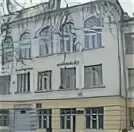

In [ ]:
show_contains(data_filterd, 'Name', 'Школа № 33 имени Карла Маркса')

In [ ]:
drop_names = ['Автомеханический техникум', 'Администрация Нижнего Новгорода',
              'Больница имени Н. В. Соловьёва', 'Нижегородское речное училище', 'Рекорд'
              'Школа № 33 имени Карла Маркса',
             ]

In [ ]:
data_filterd = data_filterd[~data_filterd.Name.isin(drop_names)].reset_index(drop=True)
print(data_filterd.shape)
data_filterd.head(2)

(285, 16)


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed church with a green roof and a steeple...,Orthodox Church in Yaroslavl,Orthodox Church in Yaroslavl arafed church wit...,orthodox church yaroslavl arafed church green ...,structure fence arafed woods buildings steeple...,265,130,30,2,41,9,29
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed view of a church with a golden cross i...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl arafed vie...,architectural ensemble yaroslavl arafed view c...,mary bell close buildings steeples people blue...,653,322,96,2,54,9,34


In [ ]:
SAVE = True
if SAVE:
    data_filterd.to_csv('data_filterd.csv', index=False)
else:
    data_filterd = pd.read_csv('data_filterd.csv')

---

## Векторная база данных

In [ ]:
# Передаем контент и метаинформацию в LangchainDocument

RAW_KNOWNLEDGE_BASE = [
    LangchainDocument(
        page_content=data_filterd["Name"][i] + ': ' + data_filterd["description"][i],
        metadata={"City": data_filterd["City"][i]
#                  , "image": data_filterd["image"][i]
                 })
    for i in tqdm(range(len(data_filterd)))
]

  0%|          | 0/285 [00:00<?, ?it/s]

In [ ]:
# Мы используем иерархический список разделителей, специально предназначенных для разделения документов Markdown
# Этот список взят из класса MarkdownTextSplitter в LangChain

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

CHUNK_SIZE = 512

TEXT_SPLITTER = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,  # Максимальное количество символов в чанке
    chunk_overlap=int(CHUNK_SIZE * 0.1),  # Количество символов, которые будут перекрываться между чанками
    add_start_index=True,  # Если "True", то включает начальный индекс чанка в метаданные
    strip_whitespace=True,  # Если значение "True", то пробелы удаляются из начала и конца каждого документа
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWNLEDGE_BASE:
    docs_processed += TEXT_SPLITTER.split_documents([doc])

No sentence-transformers model found with name Qwen/Qwen2.5-1.5B-Instruct. Creating a new one with MEAN pooling.


Model's maximum sequence length: 32768


  0%|          | 0/285 [00:00<?, ?it/s]

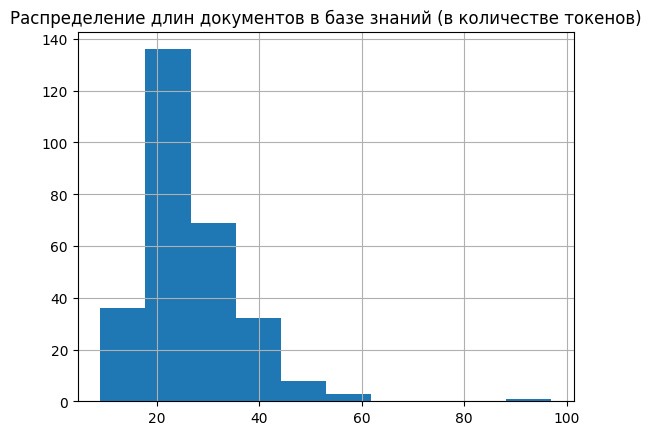

In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME,
#                                          max_length=1024
                                         )

# Чтобы получить значение max sequence_length, мы запросим базовый объект `SentenceTransformer`, используемый в RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer(MODEL_NAME).max_seq_length}")
lengths = [len(TOKENIZER.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Построим график распределения длин документов, подсчитываемых как количество токенов
fig = pd.Series(lengths).hist()
plt.title("Распределение длин документов в базе знаний (в количестве токенов)")
plt.show()

In [ ]:
def create_embedding_model(model_name):
    """
    Функция создания ембеддинг модели
    """
    try:
        embedding_model = HuggingFaceEmbeddings(
            model_name=model_name,
            multi_process=True,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"normalize_embeddings": True}, # `True` для косинусного сходства
        )

        print(f"Embedding model created")
        return embedding_model

    except Exception as e:
        print(f"Error creating embedding model: {str(e)}")
        return None

In [ ]:
%%time

EMBEDDING_MODEL = create_embedding_model(MODEL_NAME)
if EMBEDDING_MODEL:
    try:
        KNOWNLEDGE_VECTOR_DATABASE = Chroma.from_documents(docs_processed, EMBEDDING_MODEL)
        print(f"Vector database created")
    except Exception as e:
        print(f"Error creating vector database: {str(e)}")

No sentence-transformers model found with name Qwen/Qwen2.5-1.5B-Instruct. Creating a new one with MEAN pooling.


Embedding model created
Vector database created
CPU times: user 5.86 s, sys: 5.14 s, total: 11 s
Wall time: 18 s


In [ ]:
# Вставляем пользовательский запрос в то же пространство
user_query = "Что можно посмотреть в Екатеринбурге?"
query_vector = EMBEDDING_MODEL.embed_query(user_query)

In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWNLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=10)

print("\n==================================Топ похожих документов==================================")
for i in tqdm(range(len(retrieved_docs))):
    print(i, ' - '.join([retrieved_docs[i].metadata['City'],
                         retrieved_docs[i].page_content]))
    print('='*50)


Starting retrieval for user_query='Что можно посмотреть в Екатеринбурге?'...

==================================Топ похожих документов==================================


  0%|          | 0/10 [00:00<?, ?it/s]

0 Екатеринбург - Харитоновский сад: парк в Екатеринбурге
1 Екатеринбург - Дом Маева: деревянный особняк начала XX века на Вознесенской горке в Екатеринбурге
2 Екатеринбург - Екатеринбургский музей изобразительных искусств: музей в Екатеринбурге
3 Екатеринбург - Дом обороны: здание в Екатеринбурге
4 Екатеринбург - Царский мост: мост через Исеть в Екатеринбурге
5 Екатеринбург - №19 Музей истории Екатеринбурга: музей в Екатеринбурге
6 Екатеринбург - Музей истории Екатеринбурга: музей в Екатеринбурге
7 Екатеринбург - улица Чернышевского: улица в Екатеринбурге
8 Екатеринбург - Филармония: концертный зал в Екатеринбурге
9 Екатеринбург - Дом Артистов: здание в Екатеринбурге


In [ ]:
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

print(f"\nStarting retrieval for {user_query=}...")
relevant_docs = [doc.page_content for doc in retrieved_docs]
relevant_docs = RERANKER.rerank(user_query, relevant_docs, k=5)

print("==================================Топ 1 проранжированный документ==================================")
print(relevant_docs[0])


Starting retrieval for user_query='Что можно посмотреть в Екатеринбурге?'...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.94it/s]

==================================Топ 1 проранжированный документ==================================
{'content': 'Царский мост: мост через Исеть в Екатеринбурге', 'score': 26.71875, 'rank': 0, 'result_index': 4}


Наименование объекта: Царский мост, количество картинок: 39


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
230,Царский мост,Екатеринбург,мост через Исеть в Екатеринбурге,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed collage of photos of a theme park and ...,bridge through Iset in Yekaterinburg,bridge through Iset in Yekaterinburg arafed co...,bridge iset yekaterinburg arafed collage photo...,going arafed graffiti ferris standing waterfal...,434,162,52,3,12,12,32


None

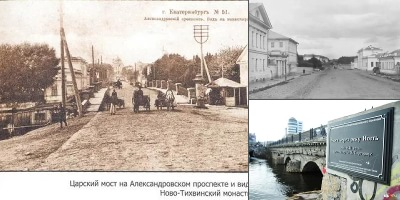

In [ ]:
show_contains(data_filterd, 'Name', relevant_docs[0]['content'].split(':')[0])

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

MODELLLM = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                                quantization_config=bnb_config)

READER_LLM = pipeline(
    model=MODELLLM,
    tokenizer=TOKENIZER,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500)

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Device set to use cuda:0


## Формирование промпта


In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.""",
    },
    {
        "role": "user",
        "content": """Контекст: {context} \n---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}""",
    },
]


RAG_PROMPT_TEMPLATE = TOKENIZER.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: {context} 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}<|im_end|>
<|im_start|>assistant



In [ ]:
relevant_docs_text = [doc['content'] for doc in relevant_docs]
context = "\nИзвлеченные документы:\n"
context += "".join([f"Документ {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question=user_query, context=context)

answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

В Екатеринбурге есть много интересных достопримечательностей и мест для посещения. Это Царский мост, улица Чернышевского, Харитоновский сад, Дом Маева (деревянный особняк), а также Филармония - это концертный зал. Кроме того, есть множество парков, исторических центров и культурных учреждений.


In [ ]:
from transformers import Pipeline

def answer_with_rag(
    question: str,
    rag_prompt: str,
    llm: Pipeline,
    knowledge_index,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
    printing: bool=True
) -> Tuple[str, List[LangchainDocument]]:
    # Соберём документы с помощью ретривера
    if printing:
        print("=> Получение документов...")
    retrieved_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in retrieved_docs]

    if reranker:
        if printing:
            print("=> Ранжирование документов...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Финальный промпт
    context = "\nИзвлеченные документы:"
    context += " ".join([f"\nДокумент {str(i)}: " + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = rag_prompt.format(question=question, context=context)
    if printing:
        print(f'Промт для RAG: \n\n{final_prompt}')
        print("=> Генерация ответа...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

---
# Проверим под каждый город!

In [ ]:
%%time

QUESTION = "Какие места стоит посетить в Екатеринбурге?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

=> Получение документов...
=> Ранжирование документов...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]

Промт для RAG: 

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: 
Извлеченные документы:
Документ 0: Каменный мост: мост через Исеть в Екатеринбурге 
Документ 1: Шарташские каменные палатки: геологический и археологический памятник природы в Екатеринбурге 
Документ 2: Храм на Крови: православный храм в Екатеринбурге 
Документ 3: Театр кукол: кинотеатр в Екатеринбурге 
Документ 4: Царский мост: мост через Исеть в Екатеринбурге 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: Какие места стоит посетить в Екатеринбурге?<|im_end|>
<|im_start|>assistant

=> Генерация ответа...


==================================Ответ==================================

В Екатеринбурге есть несколько интересных мест для посещения. Это Каменный мост (мост через Исеть), Шарташские каменные палатки (геологический и археологический памятник природы), Храм на Крови (православный храм) и Театр кукол (кинотеатр).
CPU times: user 4.32 s, sys: 483 ms, total: 4.81 s
Wall time: 8.01 s


In [ ]:
%%time

QUESTION = "Я в городе Ярославль, подскажи куда сходить?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

=> Получение документов...
=> Ранжирование документов...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.60it/s]

Промт для RAG: 

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: 
Извлеченные документы:
Документ 0: Музей истории города Ярославля: Музей истории города Ярославля 
Документ 1: Городам побратимам: Памятный знак городам-побратимам (Ярославль) 
Документ 2: Гостиный двор (Ярославль): Торговые ряды в Ярославле 
Документ 3: Ярославский дворец молодёжи: Ярославский дворец молодёжи 
Документ 4: Власьевский сквер: Городской сад в Ярославле 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: Я в городе Ярославль, подскажи куда сходить?<|im_end|>
<|im_start|>assistant

=> Генерация ответа...


==================================Ответ==================================

Можно посетить музей истории города Ярославля или прогуляться по торговым рядам в центре города. Если хотите узнать больше об истории города, можно посетить Власьевский сквер, где есть городской сад. Также стоит посмотреть Гостиный двор, если вы интересуетесь торговой культурой.
CPU times: user 3.58 s, sys: 512 ms, total: 4.09 s
Wall time: 9.26 s


In [ ]:
%%time

QUESTION = "Что посетить в Нижнем Новгороде?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

=> Получение документов...
=> Ранжирование документов...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.71it/s]

Промт для RAG: 

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: 
Извлеченные документы:
Документ 0: Печёрский Вознесенский монастырь: монастырь в Нижнем Новгороде 
Документ 1: Парк имени А.С. Пушкина: парк культуры и отдыха в Нижнем Новгороде. 
Документ 2: Обелиск Минину и Пожарскому: памятник в Нижнем Новгороде, Россия 
Документ 3: Благовещенский собор: монастырь в Нижнем Новгороде 
Документ 4: Рождественская церковь: Церковь в Нижнем Новгороде 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: Что посетить в Нижнем Новгороде?<|im_end|>
<|im_start|>assistant

=> Генерация ответа...


==================================Ответ==================================

В Нижнем Новгороде есть много интересных достопримечательностей. Вы можете посетить Печерский Вознесенский монастырь, Парк имени А. С. Пушкина, Обелиск Минину и Пожарскому, Благовещенский собор и Рождественскую церковь.
CPU times: user 3.98 s, sys: 481 ms, total: 4.46 s
Wall time: 7.69 s


In [ ]:
%%time

QUESTION = "Что посмотреть в городе Владимир?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

=> Получение документов...
=> Ранжирование документов...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.13it/s]

Промт для RAG: 

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: 
Извлеченные документы:
Документ 0: Городок Чекистов: комплекс зданий в стиле конструктивизма 
Документ 1: Владимирский централ: Тюрьма в городе Владимир 
Документ 2: Золотые ворота: памятник XII века во Владимире 
Документ 3: Парк имени А.С. Пушкина: парк культуры и отдыха в Нижнем Новгороде. 
Документ 4: Гостиный двор (Ярославль): Торговые ряды в Ярославле 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: Что посмотреть в городе Владимир?<|im_end|>
<|im_start|>assistant

=> Генерация ответа...


==================================Ответ==================================

Владимир - это древний город, который славится своими историческими памятниками. Вот несколько мест, которые стоит посетить:

1. Тюрьма в городе Владимир - это уникальное место, где можно узнать больше об истории города.

2. Памятник XII века в Великом Новгороде - это символ древнего города.

3. Церковь Святой Елены в Костромской области - это храм, который был основан в 16 веке.

4. Монастырь Успения Пресвятой Богородицы в Москве - это старейший монастырь России.

5. Дворец Ивана III в Санкт-Петербурге - это один из самых известных архитектурных памятников русского Возрождения.

Выбирайте то, что подходит вам больше всего!
CPU times: user 9.41 s, sys: 1.3 s, total: 10.7 s
Wall time: 13.5 s


---

# Метрики

# RAGAS

## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

In [ ]:
# Загрузим модель для извлечения ембеддингов по тексту
emb_model = SentenceTransformer(MODEL_NAME)

def data_preprocess(df, n_samples):
    """
    Функция генерации датасета (семплирование) для проверки нашей RAG системы
        df - датафрейм
        n_samples - количество взятых наблюдений
    """
    sample = df.sample(n_samples, random_state=SEED)

    question = list()
    ground_truths = list()

    for i, row in sample.iterrows():
        question.append(f"Что можно посмотреть в городе {row['City']}?")
        ground_truths.append(row['Name'])

    gen_sample = pd.DataFrame({'question': question,
                               'ground_truths': ground_truths})

    return gen_sample

def answer_relevancy(df, embedding_model):
    """
    Функция для расчета метрики answer relevancy
        df - датафрейм
        embedding_model - модель для извлечения эмбеддингов
    """
    scores = list()

    for i, row in tqdm(df.iterrows()):
        question_emb = embedding_model.encode(row['question'])
        answer_emb = embedding_model.encode(row['answer'])
        scores.append(cosine_similarity([answer_emb], [question_emb])[0][0])

    return (sum(scores)/len(df))

No sentence-transformers model found with name Qwen/Qwen2.5-1.5B-Instruct. Creating a new one with MEAN pooling.


# Тест RAG

In [ ]:
data_gen = data_preprocess(data_filterd, 100)
print(data_gen.shape)
data_gen.head()

(100, 2)


,question,ground_truths
0,Что можно посмотреть в городе Нижний Новгород?,Благовещенский монастырь
1,Что можно посмотреть в городе Нижний Новгород?,Церковь во имя Всемирлостивейшего Спаса
2,Что можно посмотреть в городе Ярославль?,Парк 1000-летия Ярославля
3,Что можно посмотреть в городе Екатеринбург?,Усадьба Тарасова
4,Что можно посмотреть в городе Нижний Новгород?,Дом-музей Добролюбова


In [ ]:
new_prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Ты путешественник. Резюмируя информацию, которая содержится в контексте, ответь на вопрос.""",
    },
    {
        "role": "user",
        "content": """Контекст: {context} \n---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}""",
    },
]


NEW_RAG_PROMPT_TEMPLATE = TOKENIZER.apply_chat_template(
    new_prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(NEW_RAG_PROMPT_TEMPLATE)

<|im_start|>system
Ты путешественник. Резюмируя информацию, которая содержится в контексте, ответь на вопрос.<|im_end|>
<|im_start|>user
Контекст: {context} 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}<|im_end|>
<|im_start|>assistant



In [ ]:
%%time

answers = list()
contexts = list()
for i, row in tqdm(data_gen.iterrows()):
    answer, context = answer_with_rag(row['question'],
                                NEW_RAG_PROMPT_TEMPLATE,
                                READER_LLM,
                                KNOWNLEDGE_VECTOR_DATABASE,
                                reranker=RERANKER,
                                printing=False)
    answers.append(answer)
    contexts.append('; '.join([i for i in context]))

data_gen['contexts'] = contexts
data_gen['answer'] = answers
print(data_gen.shape)
data_gen.head()

0it [00:00, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.90it/s]
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.25it/s]

100%|███████████████████████████████

(100, 4)
CPU times: user 10min 59s, sys: 1min 30s, total: 12min 29s
Wall time: 19min 41s


,question,ground_truths,contexts,answer
0,Что можно посмотреть в городе Нижний Новгород?,Благовещенский монастырь,Каменный мост: мост через Исеть в Екатеринбург...,В городе Нижний Новгород можно посетить многоц...
1,Что можно посмотреть в городе Нижний Новгород?,Церковь во имя Всемирлостивейшего Спаса,Каменный мост: мост через Исеть в Екатеринбург...,В городе Нижний Новгород можно посетить многоц...
2,Что можно посмотреть в городе Ярославль?,Парк 1000-летия Ярославля,Городок Чекистов: комплекс зданий в стиле конс...,В городе Ярославль можно посетить часовню Алек...
3,Что можно посмотреть в городе Екатеринбург?,Усадьба Тарасова,Каменный мост: мост через Исеть в Екатеринбург...,В городе Екатеринбург можно посетить множество...
4,Что можно посмотреть в городе Нижний Новгород?,Дом-музей Добролюбова,Каменный мост: мост через Исеть в Екатеринбург...,В городе Нижний Новгород можно посетить многоц...


In [ ]:
%%time

AR = answer_relevancy(data_gen, emb_model)
AR

0it [00:00, ?it/s]

CPU times: user 10.4 s, sys: 989 ms, total: 11.4 s
Wall time: 10.5 s


0.9510248506069183

# Выводы RAGу:
1) Был проведен анализ источника. Чтобы работать с текстом по каждому из достопримечательностей - сгруппировал данные по Name, City, Description и применил аггрегирующую функцию set для английского описания изображения и сами изображения\\
2) Для выявления выбросов:
   * перевел description на английский язык
   * соединил с английским описание изображения
   * применил предобработку и tfidfvectorizer
   * применил кластеризацию, перед этим запустив поиск оптимального количества кластеров
   * в конце концов посмотрел глазами на отобранные Name в данных и провел ручную чистку (училища, больницы, имена и др)
3) Для системы RAG пользовалься Qwen2.5 - 1.5B, взял векторную базу Chrome
4) Хуже всего отработал на городе Владимир - так как меньше всего данных у модели было именно по нему.
5) Предыдущий результат можно заметить и на PCA / UMAP визуализации, именно Владимир как то замешивается с векторами других городов... (по Ярославлю можно заметить пару выбросов, можно проанализировать и избавиться, или же оставить отличительной чертой относительно других городов)
6) Сгенерирован датасет для тестировани RAGAS.
   * метрика answer relevancy = 0.9510248506069183, показывает высокие значения, а значит RAG старается отвечать на тот вопрос, который был нами задан.
   